In [1]:
# #uncomment if you're running from colab
# %tensorflow_version 2.x

%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import deque, Counter
import random
import gym
from datetime import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tqdm import tqdm_notebook

In [2]:
from solutions.memories import PrioritizedNStepMemory
from solutions.networks import NoisyDuelingNetwork
from solutions.agents import DQNAgent

# env = gym.make('MountainCar-v0')
env = gym.make('CartPole-v1')
mem = PrioritizedNStepMemory(int(1e5))
a = DQNAgent(state_size = env.reset().shape[0], hidden_sizes = [64,64],
             action_size = env.action_space.n, replay_memory = mem,
             double=True, Architecture=NoisyDuelingNetwork)

In [3]:
scores = []
scores_deque = deque(maxlen=100) 
moving_scores = []
start_time = datetime.now()
solved_score=200
action_df = []
weight_df = []

for i in tqdm_notebook(range(10000)):
    if (i+1) % 100==0: print(f'Episdoe {i} Moving Average: {np.mean(scores_deque)}')
    state = env.reset()
    score = 0
    t=0
    actions = []
    while True:
        t+=1
        #select action
        action = a.act(state)  
        actions.append(action)

        #env step
        next_state, reward, done, info = env.step(action)   
        
        #engineer the reward to motivate your agent even more
        if done: 
            fake_reward = reward 
        else:
            fake_reward = reward
        
        #agent step
        a.step(state,action,fake_reward,next_state,done)
        
        #collect score
        score += reward
        
        #go to next state
        state = next_state   
        
        #break if done
        if done: break
            
    #book keeping
    scores.append(score)
    scores_deque.append(score)
    moving_scores.append(np.mean(scores_deque))
    action_df.append(Counter(actions))
    weight_df.append([tf.reduce_mean(i).numpy() for i in a.network_local.get_weights()])

    if moving_scores[-1] > solved_score: 
        print(f'Solved at Play {i}: {datetime.now() - start_time} Moving average: {moving_scores[-1]}')
        break

C:\Users\sukri\anaconda3\envs\rl-gpu\lib\site-packages\ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


Episdoe 99 Moving Average: 9.535353535353535
Episdoe 199 Moving Average: 9.43
Episdoe 299 Moving Average: 9.43
Episdoe 399 Moving Average: 9.32
Episdoe 499 Moving Average: 9.31
Episdoe 599 Moving Average: 9.37
Episdoe 699 Moving Average: 9.43
Episdoe 799 Moving Average: 9.32
Episdoe 899 Moving Average: 9.43
Episdoe 999 Moving Average: 9.43
Episdoe 1099 Moving Average: 9.35
Episdoe 1199 Moving Average: 9.23
Episdoe 1299 Moving Average: 9.49
Episdoe 1399 Moving Average: 9.42
Episdoe 1499 Moving Average: 9.81
Episdoe 1599 Moving Average: 22.41
Episdoe 1699 Moving Average: 20.44
Episdoe 1799 Moving Average: 22.19
Episdoe 1899 Moving Average: 22.72
Episdoe 1999 Moving Average: 25.07
Episdoe 2099 Moving Average: 25.0
Episdoe 2199 Moving Average: 26.03
Episdoe 2299 Moving Average: 27.67
Episdoe 2399 Moving Average: 31.18
Episdoe 2499 Moving Average: 60.27
Episdoe 2599 Moving Average: 109.72
Episdoe 2699 Moving Average: 133.29
Episdoe 2799 Moving Average: 146.52
Episdoe 2899 Moving Average: 16

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Int64Index([6], dtype='int64'). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

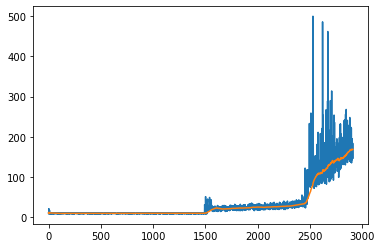

In [4]:
import matplotlib.pyplot as plt
plt.plot(scores)
plt.plot(moving_scores)

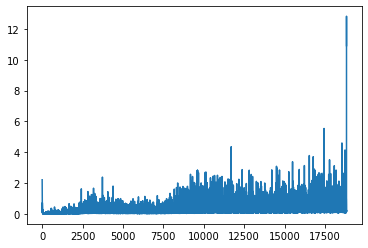

In [5]:
plt.plot(a.losses)

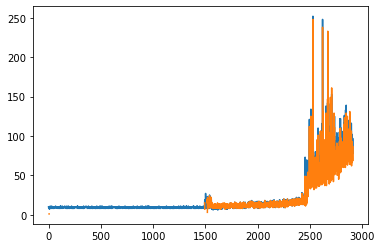

In [6]:
action_df = pd.DataFrame(action_df)
for i in action_df.columns:
    plt.plot(action_df[i])

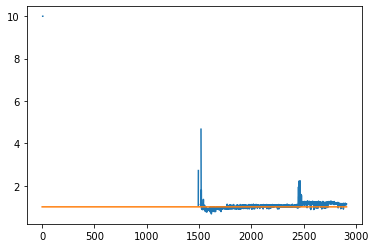

In [7]:
plt.plot(action_df[0]/action_df[1])
plt.plot([1 for i in range(action_df.shape[0])])

No handles with labels found to put in legend.


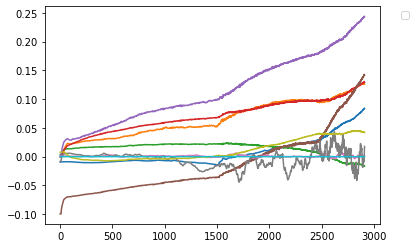

In [8]:
weight_df = pd.DataFrame(weight_df)
weight_df.columns = [str(i.shape) for i in a.network_local.get_weights()]
for i in range(weight_df.shape[1]):
    plt.plot(weight_df.iloc[:,i])
plt.legend(bbox_to_anchor=(1.05,1),loc=2)